# <center> SNR comparison of 20, 32, and 64 channel head coils

## Benefits of array coils
 - ### Improved SNR close to the coil elements
 - ### Enable spatial encoding by coil element location (parallel imaging). This allows us to reduce the number of phase encoding steps (GRAPPA) and/or the number of slice excitation pulses (multiband). This lets us scan faster, reach higher resolutions, and reduce susceptibility distortions

<img src="https://www.dartmouth.edu/dbic/images/coils3.png" width = "600">

 - ### 64 and 32 channel coils are similar in internal size, smaller than 20 ch
 - ### 64 and 20 channel coils include neck elements, have hole in the top

<img src="https://onlinelibrary.wiley.com/cms/asset/ef758364-2fc5-4421-be66-c4123f3d4c2d/mfig001.jpg" width=600>

### Parallel imaging performance goes up as the number of elements increases, but is limited by electrical coupling between elements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import nibabel as nib
import math
import seaborn as sns
plt.rcParams['figure.dpi'] = 96*2

In [2]:
workdir = Path('../../lcni/headcoil_snr')

In [3]:
images = {}
for mprage in workdir.glob('*mprage*ch.nii'):
    images[mprage.stem.split('_')[-1]] = nib.load(str(mprage))

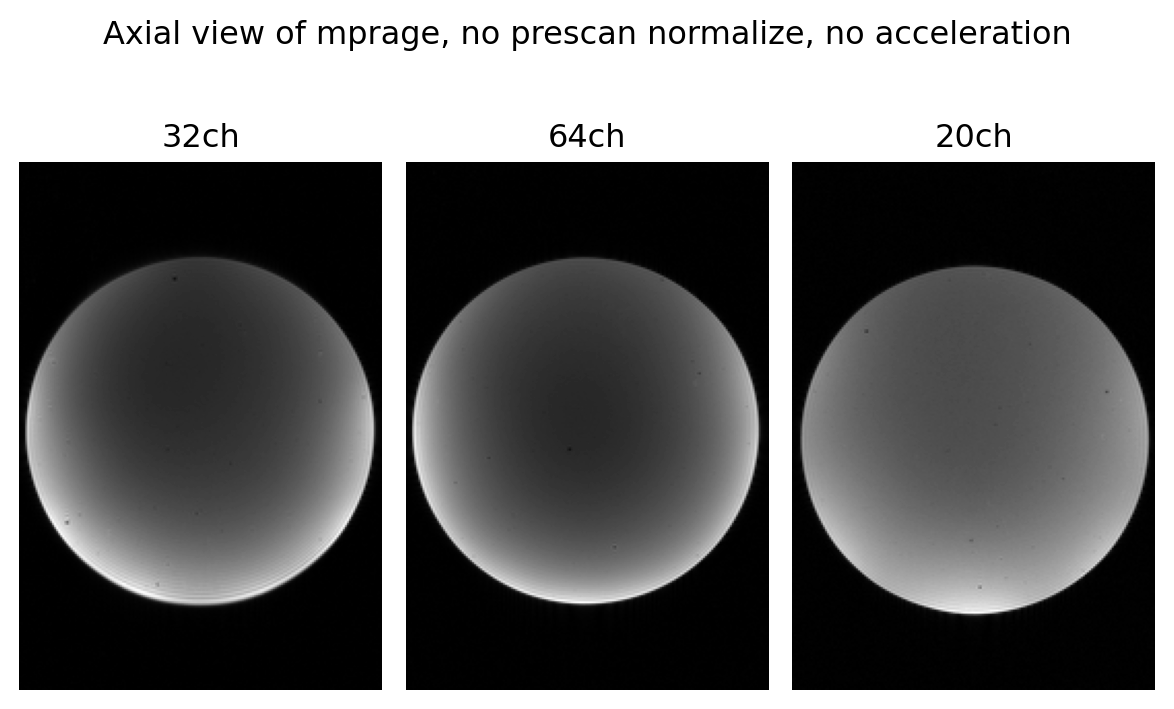

In [4]:
fig, axes = plt.subplots(1, len(images), constrained_layout=True)
fig.suptitle('Axial view of mprage, no prescan normalize, no acceleration')
for i, name in enumerate(images):
    axes[i].imshow(images[name].get_fdata()[:,128,:], cmap = 'gray')
    axes[i].axis('off')
    axes[i].set_title(name)
plt.show()

## Note that the image from the 20 ch coil is more uniform, and that the phantom is not perfectly centered vertically in each coil. 
## To compare image quality, we need to calculate the signal-to-noise ratio. IMPORTANT CAVEAT: the following method includes certain assumptions about the noise distribution that may not be true for all cases. There are other ways to calculate this but they require more data.

$$\Large
SNR = \frac{mean(signal)}{std dev(background)\sqrt{2}}
$$

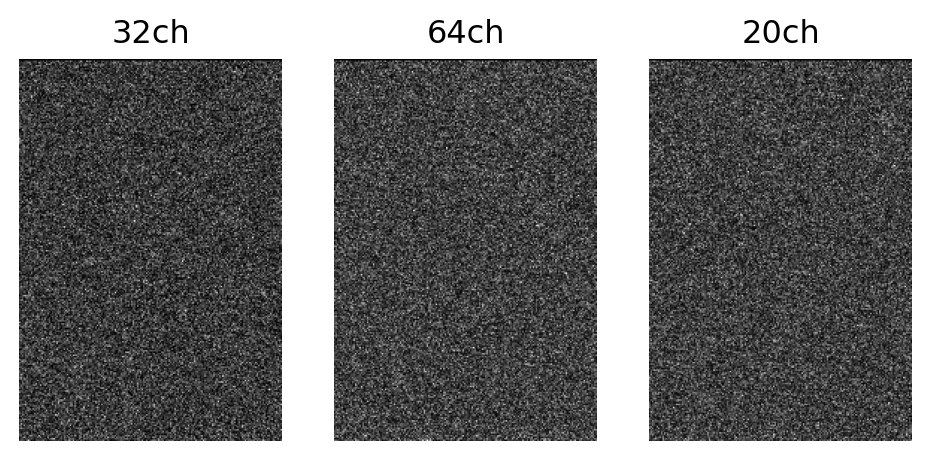

In [5]:
# Check our background
fig, axes = plt.subplots(1, len(images))
for i, name in enumerate(images):
    axes[i].imshow(images[name].get_fdata()[:,250,:], cmap = 'gray')
    axes[i].axis('off')
    axes[i].set_title(name)
plt.show()

In [6]:
snr = {name: img.get_fdata()/(np.std(img.get_fdata()[:,250,:])*math.sqrt(2)) for name, img in images.items()}

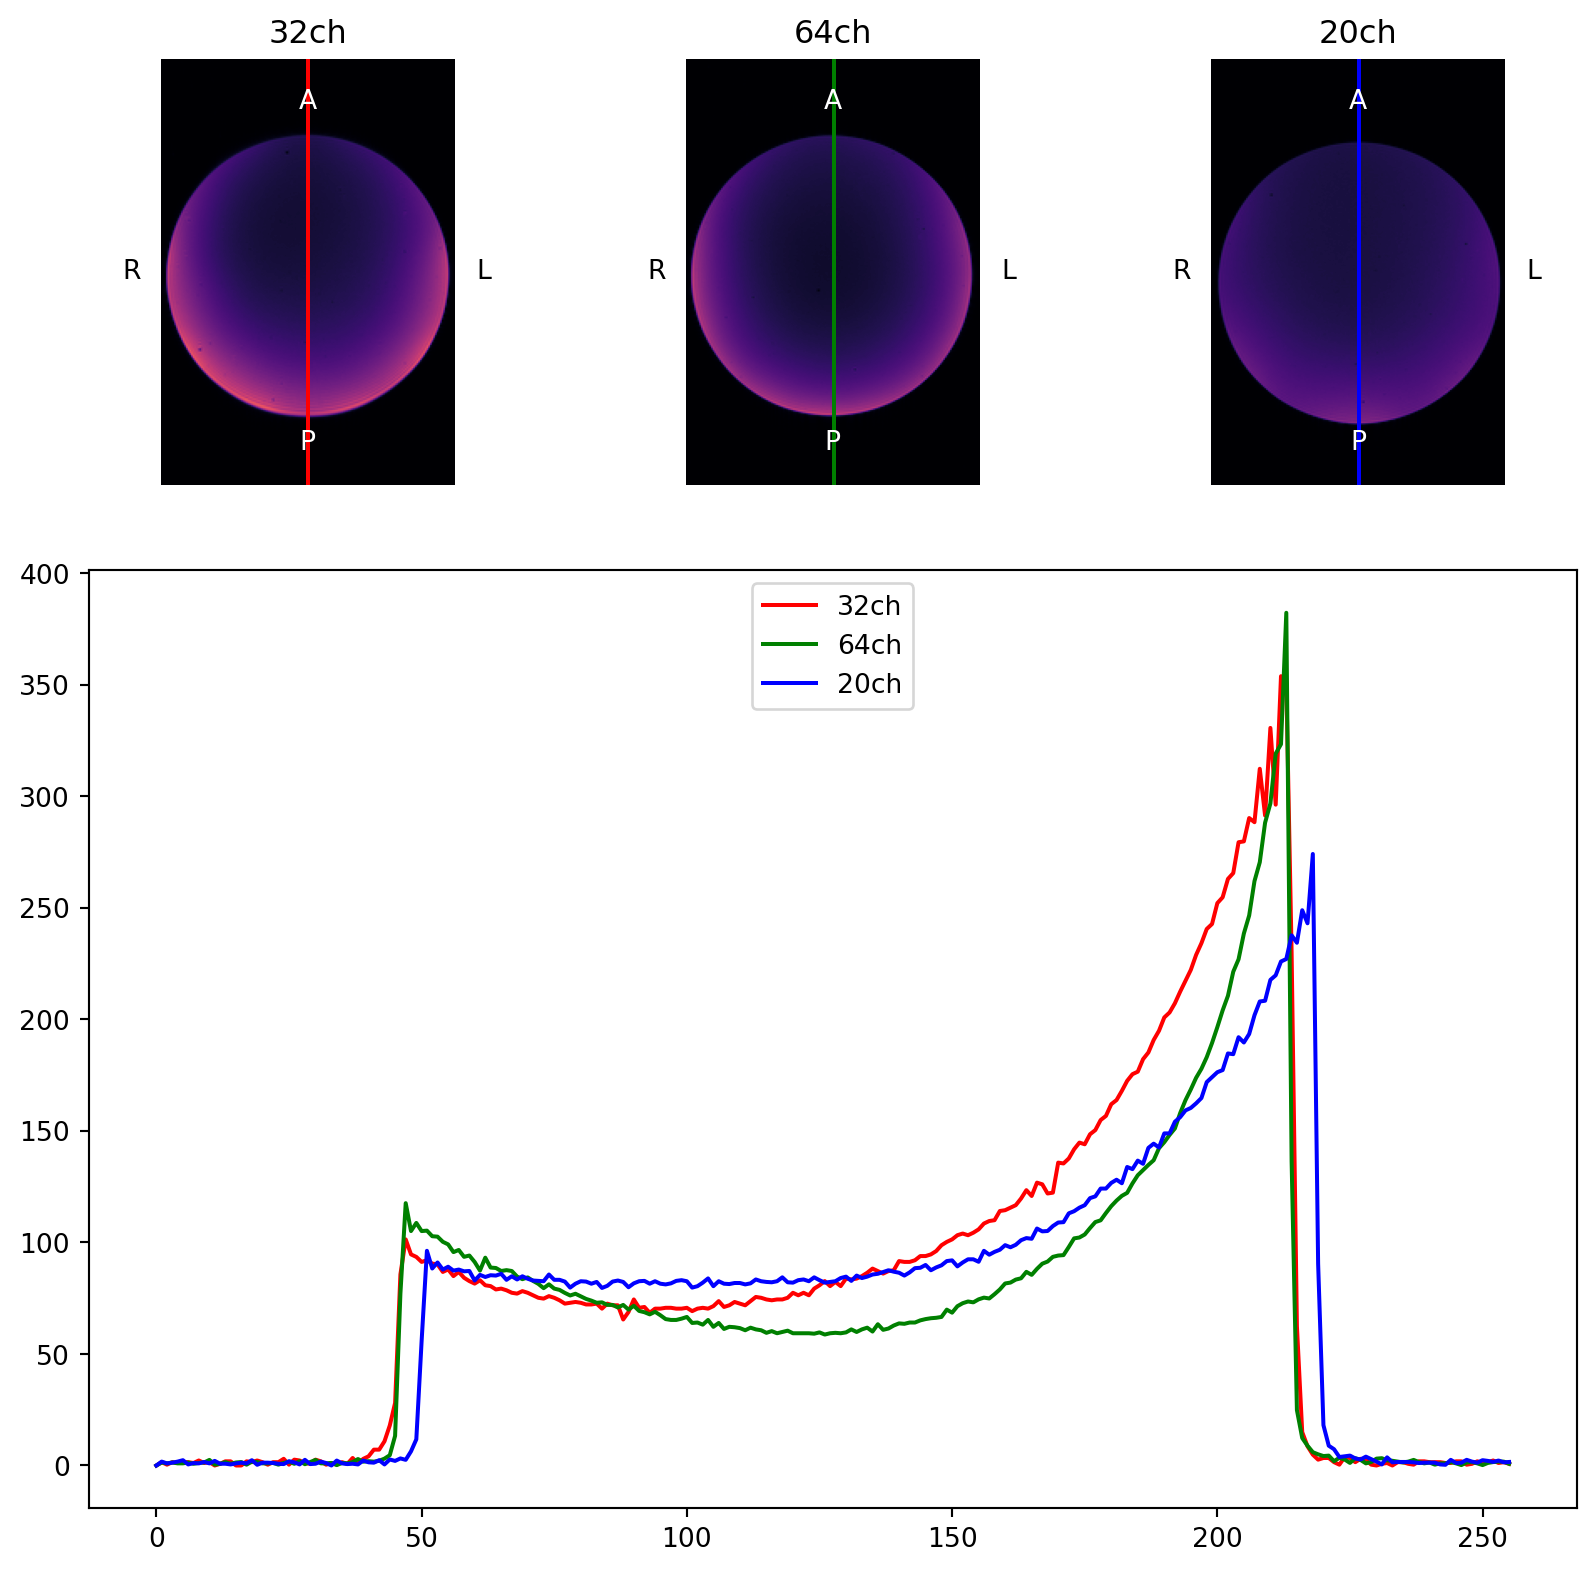

In [7]:
fig = plt.figure(figsize=(10, 10))
grid = plt.GridSpec(3,3)
kwargs = {'xycoords':'axes fraction', 'horizontalalignment':'center', 'verticalalignment':'center'}
im_ax = []
colors = ['r', 'g', 'b']
for i in range(0,3):
    im_ax.append(fig.add_subplot(grid[0, i]))
plot_ax = fig.add_subplot(grid[1:, :])
for index, name in enumerate(snr):
    im_ax[index].imshow(snr[name][:,128,:], vmin = 0, vmax = 700, cmap = 'magma')
    im_ax[index].axvline(x = 88, color = colors[index])
    im_ax[index].axis('off')
    im_ax[index].title.set_text(name)
    im_ax[index].annotate('A', xy = (0.5, 0.9),  color = 'white', **kwargs)
    im_ax[index].annotate('P', xy = (0.5, .1),   color = 'white', **kwargs)
    im_ax[index].annotate('R', xy = (-0.1, 0.5), color = 'black', **kwargs)
    im_ax[index].annotate('L', xy = (1.1, 0.5),  color = 'black', **kwargs)
    plot_ax.plot(snr[name][:, 128, 88], label = name, color = colors[index])
plot_ax.legend(loc = 'upper center')
plt.show()

***

## Phantom data is all well and good, but what does this mean in actual brains? We repeated this in a volunteer, segmented the brain using Freesurfer, and calculated the average SNR in each segmented brain region. NB the following results do not include the root(2) correction factor

In [8]:
invivo_dir = workdir / 'snr_test_1'

In [9]:
invivo_snr = {}
for filename in invivo_dir.glob('snr*.nii.gz'):
    invivo_snr['{}ch'.format(filename.stem[:5])] = nib.load(str(filename))

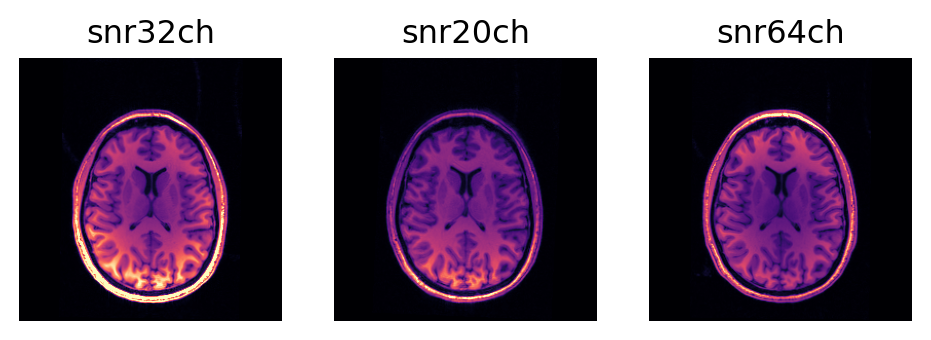

In [10]:
fig, axes = plt.subplots(1, len(invivo_snr))
for i, name in enumerate(invivo_snr):
    axes[i].imshow(np.rot90(invivo_snr[name].get_fdata()[:,:,160]), cmap = 'magma', vmin = 0, vmax = 150)
    axes[i].axis('off')
    axes[i].set_title(name)
plt.show()

## Note one of the difficulties of comparing these coils -- subject head placement. There's better SNR closer to the coil elements.

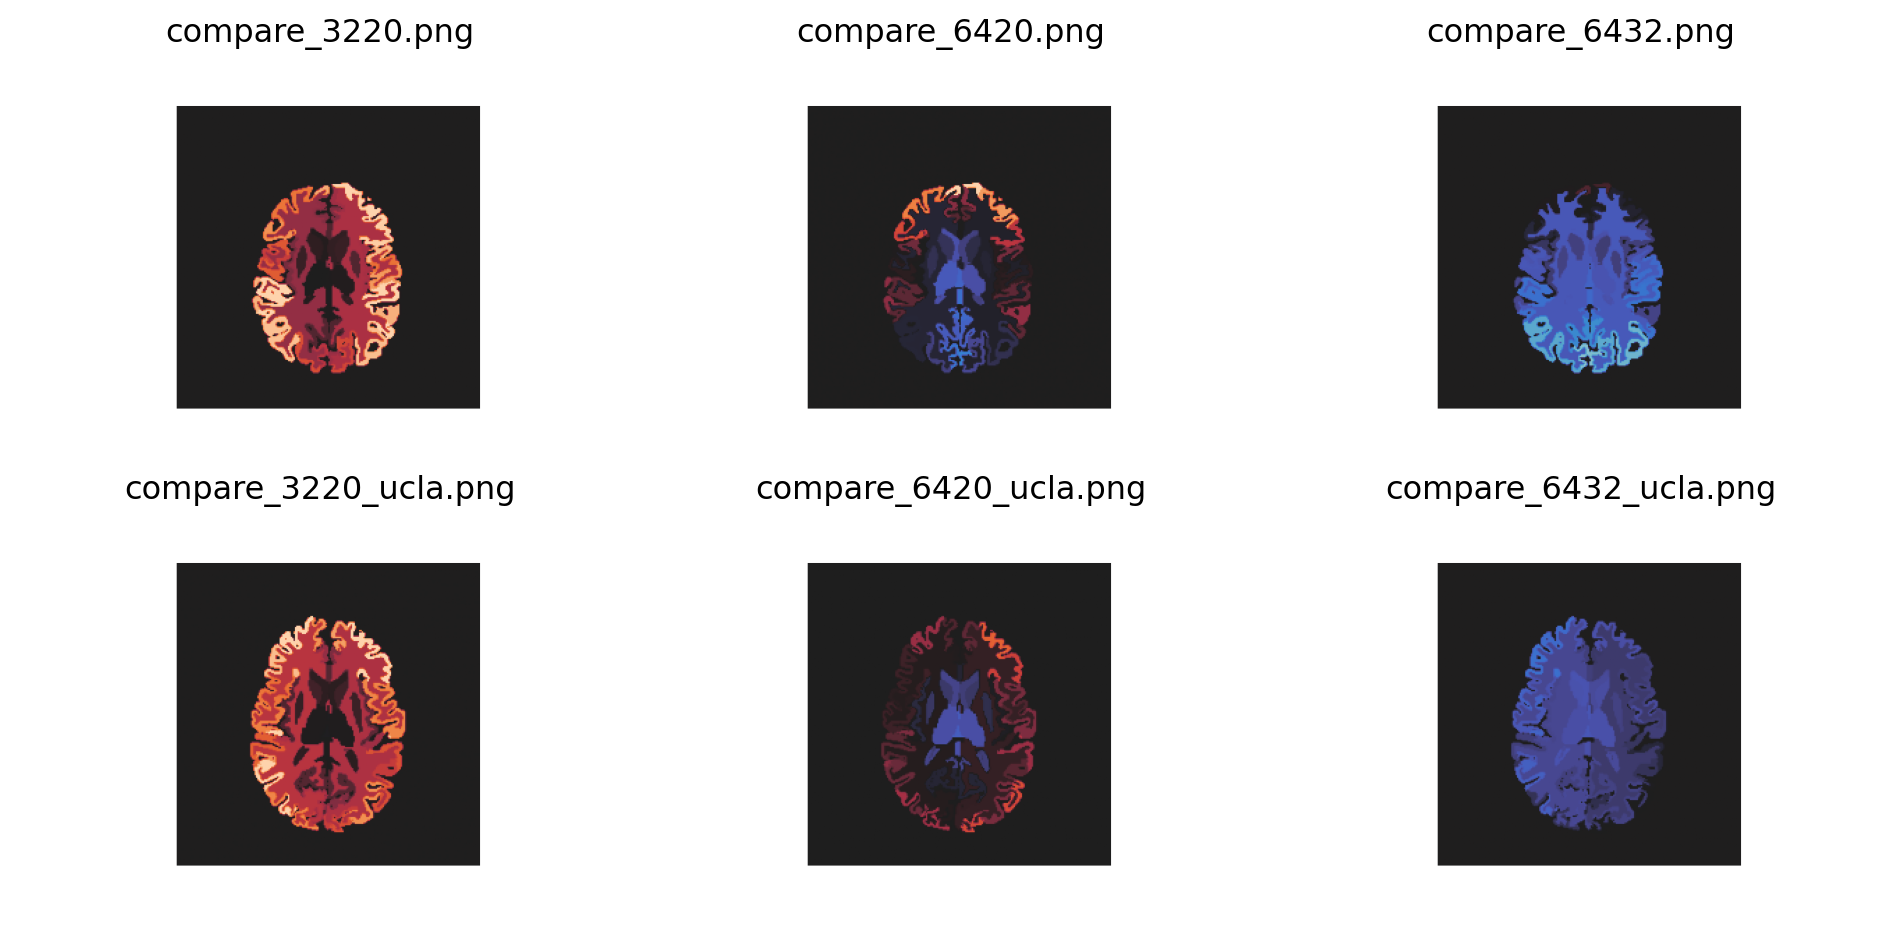

In [11]:
import matplotlib.image as mpimg
labels = ['3220', '6420', '6432']
fig, axes = plt.subplots(2, len(labels), tight_layout = True, figsize = (10,5))
for i, label in enumerate(labels):
    lcni = 'compare_{}.png'.format(label)
    ucla = 'compare_{}_ucla.png'.format(label)
    lcni_img = mpimg.imread(lcni)
    ucla_img = mpimg.imread(ucla)
    axes[0, i].imshow(lcni_img)
    axes[0, i].axis('off')
    axes[0, i].set_title(lcni)
    axes[1, i].imshow(ucla_img)
    axes[1, i].axis('off')
    axes[1, i].set_title(ucla)
plt.show()

***

## For functional imaging, what we are really concerned about is the temporal snr: 
$$\Large
tSNR = \frac{tmean(signal)}{std dev(signal)}
$$

In [12]:
fields = ['number', 'label', 'r', 'g', 'b', 'a']
parcels = dict()          
import csv
with open('/packages/freesurfer/6.0.0/freesurfer/FreeSurferColorLUT.txt') as fp:
    rdr = csv.DictReader(filter(lambda row: row[0]!='#', fp), fieldnames = fields,
                        delimiter = ' ', skipinitialspace = True)
    for row in rdr:
        parcels[int(row['number'])] = row['label']

In [13]:
seg_reorient_data = nib.load(str(invivo_dir / 'seg_reorient.nii.gz')).get_fdata()
tsnr_32_data = nib.load(str(invivo_dir / 'tsnr_32ch_reg.nii.gz')).get_fdata()
tsnr_64_data = nib.load(str(invivo_dir / 'tsnr_64ch_reg.nii.gz')).get_fdata()
snr_32_data = nib.load(str(invivo_dir / 'snr32_reg.nii.gz')).get_fdata()
snr_64_data = nib.load(str(invivo_dir / 'snr64_reg.nii.gz')).get_fdata()

In [14]:
tdiff_img_data = np.zeros_like(tsnr_64_data)
sdiff_img_data = np.zeros_like(snr_64_data)
for index in parcels:
    vox_count = np.count_nonzero(seg_reorient_data == index)
    if vox_count:
        snr_32 = np.mean(snr_32_data[np.nonzero(seg_reorient_data == index)])
        snr_64 = np.mean(snr_64_data[np.nonzero(seg_reorient_data == index)])
        perc_diff = (snr_64 - snr_32)/snr_32
        sdiff_img_data[np.nonzero(seg_reorient_data == index)] = perc_diff
        tsnr_32 = np.mean(tsnr_32_data[np.nonzero(seg_reorient_data == index)])
        tsnr_64 = np.mean(tsnr_64_data[np.nonzero(seg_reorient_data == index)])
        perc_diff = (tsnr_64 - tsnr_32)/tsnr_32
        tdiff_img_data[np.nonzero(seg_reorient_data == index)] = perc_diff

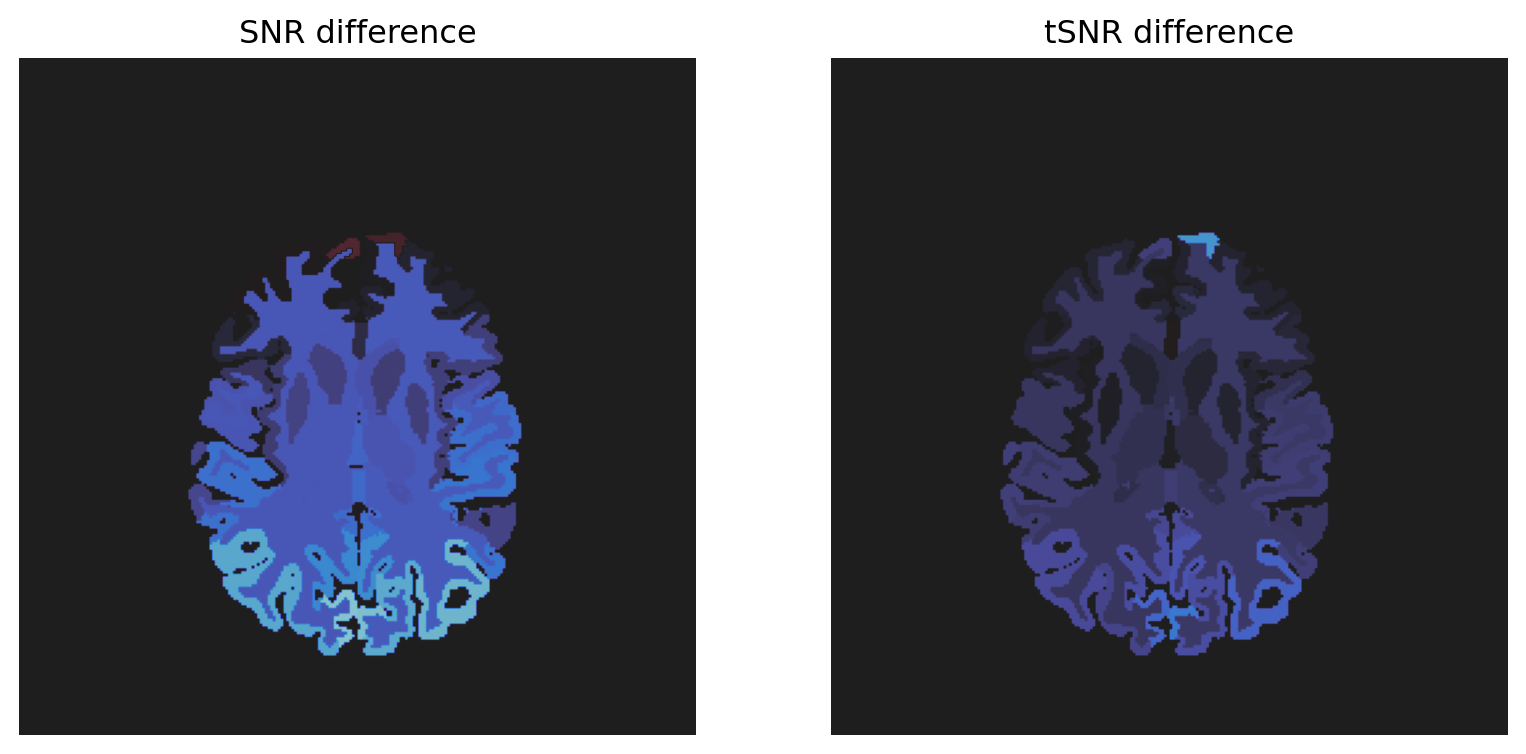

In [15]:
fig, axes = plt.subplots(1,2, figsize = (10,10))
axes[0].imshow(np.rot90(sdiff_img_data[:,:,160]), cmap =sns.color_palette("icefire", as_cmap = True), vmin = -.5, vmax = .5)
axes[0].axis('off')
axes[0].set_title('SNR difference')
axes[1].imshow(np.rot90(tdiff_img_data[:,:,160]), cmap =sns.color_palette("icefire", as_cmap = True), vmin = -.5, vmax = .5)
axes[1].set_title('tSNR difference')
axes[1].axis('off')
plt.show()

## What does this tell us? Once we consider all the other factors that contribute to tSNR, the impact of choosing a headcoil diminishes; however the 32 channel coil still has better tSNR than the 64 in all brain regions.

***
# <center> Parallel imaging performance

In [16]:
grappadir = workdir / 'grappa_test'

In [17]:
g_images = {}
for mprage in grappadir.glob('*mprage*ch*.nii'):
    g_images[mprage.stem] = nib.load(str(mprage))

In [18]:
channels = ['20ch', '32ch', '64ch']
accel = ['p{}'.format(x) for x in range(1,9)]

In [19]:
from skimage import exposure

In [ ]:
fig, axes = plt.subplots(8, 3, figsize=(18,48))
for row, g_factor in enumerate(accel):
    for col, channel in enumerate(channels):
        name = 'mprage_{}_{}'.format(channel, g_factor)
        axes[row, col].imshow(np.rot90(g_images[name].get_fdata()[:,:,88]), cmap = 'gray', vmax = 1000)
        axes[row, col].axis('off')
        axes[row, col].set_title(name)
plt.show()

## The image quality reduction with acceleration is characterized by a spacially dependent "g-factor". I'm going to calculate this using a method from Imai H etal,. [Signal-to-noise ratio measurement in parallel MRI with subtraction mapping and consecutive methods]. Nihon Hoshasen Gijutsu Gakkai Zasshi. 2008 Aug 20;64(8):930-6. Japanese. doi: 10.6009/jjrt.64.930. PMID: 18772535.

In [ ]:
from scipy.ndimage import generic_filter

In [ ]:
diff_images = {}
snr_images = {}
gf_images = {}
for coil in channels:
    no_accel = 'mprage_{}_p1'.format(coil)
    no_accel_img = g_images[no_accel].get_fdata()[:,:,88]
    no_accel_snr = no_accel_img/(np.std(g_images[no_accel].get_fdata()[:,250,:])*math.sqrt(2))
    for ipat in range(2,9):
        name = 'mprage_{}_p{}'.format(coil, ipat)
        img = g_images[name].get_fdata()[:,:,88]
        diff_images[name] = np.abs(no_accel_img - img)
        snr_images[name] = generic_filter(img, np.mean, size = 7)/generic_filter((no_accel_img - img), np.std, size = 7)
        gf_images[name] = no_accel_snr/(snr_images[name]*math.sqrt(ipat))

In [ ]:
fig, axes = plt.subplots(7, 3, figsize=(18,48))
for row, ipat in enumerate(accel[1:]):
    for col, channel in enumerate(channels):
        name = 'mprage_{}_{}'.format(channel, ipat)
        axes[row, col].imshow(np.rot90(gf_images[name]), vmin = 0, vmax = 30)
        axes[row, col].axis('off')
        axes[row, col].set_title(name)
plt.show()